In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, PredefinedSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [177]:
data = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/10_Data_Clean/xgboost_data.csv")

In [178]:
data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%),ROLLING_1yr_PRICE_CHANGE,HOME_PRICE_LAG1,PRICE_CHANGE_LAG1,PRICE_CHANGE_DIFF,PREV_MAX_PCT_ZIP_BURNED,FIRE_LAST_YEAR,FIRE_SHOCK
0,35658.0,54480,263100.0,4.24,0.4056,90001,2012,89.369276,30.632127,16.684648,...,249600.0,-13500.0,-5.131129,NaN,NaN,NaN,NaN,0.0,0,0
1,35097.0,54760,249600.0,4.23,0.4108,90001,2013,87.745738,32.055698,17.057243,...,241800.0,-7800.0,-3.125000,-5.131129,263100.0,-13500.0,5700.0,0.0,0,0
2,34050.0,56314,241800.0,4.22,0.4181,90001,2014,87.023960,33.644361,18.102684,...,258500.0,16700.0,6.906534,-3.125000,249600.0,-7800.0,24500.0,0.0,0,0
3,33887.0,57227,258500.0,4.25,0.4223,90001,2015,87.329232,32.517250,17.484799,...,272200.0,13700.0,5.299807,6.906534,241800.0,16700.0,-3000.0,0.0,0,0
4,34323.0,57942,272200.0,4.26,0.4224,90001,2016,87.720183,32.676417,18.821322,...,305500.0,33300.0,12.233652,5.299807,258500.0,13700.0,19600.0,0.0,0,0


In [179]:

###########################################
# Subset X and Y features
###########################################

# Select our Y target variable
y = data["PCT_PRICE_CHANGE (%)"]

# Select our X features

# Columns to drop from X
col_drop = ["PCT_PRICE_CHANGE (%)", "PRICE", "NEXT_YEAR_PRICE", "PRICE_CHANGE"]

# Features
X = data.drop(columns=col_drop)

In [180]:
data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK'],
      dtype='object')

In [181]:
y 

0        -5.131129
1        -3.125000
2         6.906534
3         5.299807
4        12.233652
           ...    
11288     4.889179
11289    -3.418272
11290    -5.405405
11291    -9.319728
11292     2.775694
Name: PCT_PRICE_CHANGE (%), Length: 11293, dtype: float64

In [182]:
###########################################
# Divide Dataset for NOT scaled
###########################################

#100% of data
#│
#│── 80% → Training + Validation (X_temp, y_temp)
#│    ├── 64% → Training (X_train_split, y_train_split)
#│    └── 16% → Validation (X_val_split, y_val_split)
#│
#│── 20% → Test (X_test, y_test)


# STEP 1: Split full data into training + test (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# STEP 2: From training, create validation split (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.2,
    random_state=42
)

# STEP 3: PredefinedSplit to use train/val split in tuning
val_fold = np.concatenate([
    -1 * np.ones(len(y_train)),  # training = -1
     np.zeros(len(y_val))        # validation = 0
])
predefined_split = PredefinedSplit(val_fold)

# STEP 4: Combine train + val for RandomizedSearchCV
X_search = np.concatenate([X_train, X_val])
y_search = np.concatenate([y_train, y_val])



In [183]:
###########################################
# XGBOOST MODEL
###########################################

# STEP 1: Define XGBoost Regressor
xgb_model = XGBRegressor(eval_metric='rmse', random_state=42)

# STEP 2: Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}


# STEP 3: Run RandomizedSearchCV using PredefinedSplit
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=predefined_split,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_search, y_search)

# STEP 4: Retrain best model on full training set
best_xgb = xgb_search.best_estimator_
best_xgb.fit(X_trainval, y_trainval)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

MAE:  1.94
MSE:  32.83
RMSE: 5.73
R²:   0.7451
Mean of y_test: 4.057508641504727
Std of y_test: 11.348474022053876


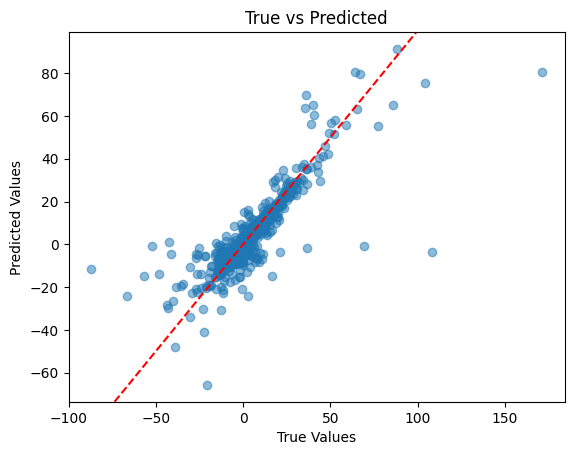

In [184]:
###########################################
# PERFORMANCE METRICS
###########################################

# Predict on test set
y_pred = best_xgb.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

# Check basic distribution of y_test
print("Mean of y_test:", np.mean(y_test))
print("Std of y_test:", np.std(y_test))

# Compare to model predictions
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()



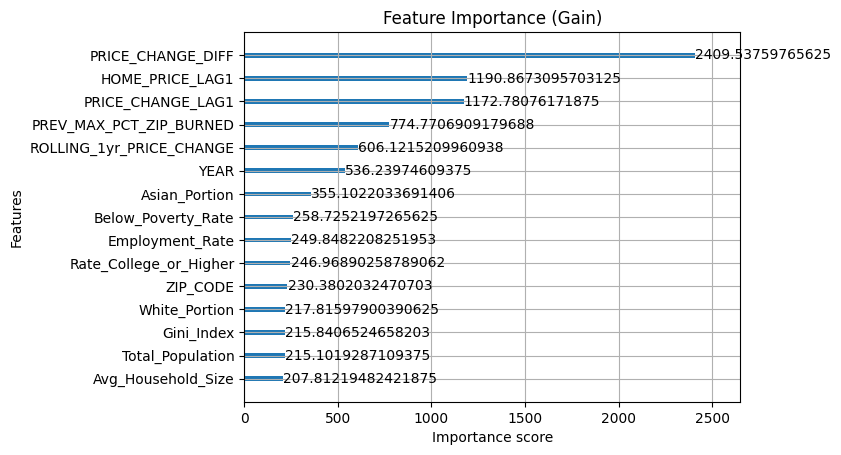

In [185]:
###########################################
# FEATURE IMPORTANCE
###########################################

from xgboost import plot_importance


plot_importance(best_xgb, max_num_features=15, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

